### Compare thresholds for biology inside and out of polynyas

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

### Get the CESM2 4p4z tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 6.34 s, sys: 368 ms, total: 6.71 s
Wall time: 9 s


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude to the same length as polynas and fix time

In [5]:
ds = ds.isel(nlat=slice(0,76))

In [6]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Get coords

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)

### Make the biological variables 2-D

In [8]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

Drop the 3-D vars now

In [9]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['z_t','z_t_150m'])

### update the variable list

In [10]:
#redefine variable list
variables = ['phytoC_TOT_zint','zooC_TOT_zint'] # 'spC_zint','coccoC_zint','diatC_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             #'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             #'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            #'IFRAC','phytoC_TOT_zint','zooC_TOT_zint']

### Get polynya masks

#### 0 = not a polynya
#### 1 = open water polynya
#### 2 = coastal polynya


#### get ds read in and ready function

In [11]:
def get_data(path,case,thres_var,thres):
    
    file = path + case + '.' + thres_var + '_' + thres + 'thresh.polynya_sh.006201-012212.nc'

    ds_poly = xr.open_dataset(file, drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    return ds_poly

thres_vars: hi and aice

aice thresholds range from 15% to 85%
hi thresholds range from 0.1m to 0.85m

### do aice thresholds first

In [15]:
ts_polys = xr.Dataset({v: ds[v] for v in ['time']})
ts_non_polys = xr.Dataset({v: ds[v] for v in ['time']})

In [19]:
thres_var = 'aice'

for var in variables:
    
    for thres in ['15%','50%','85%']:
        
        print(var, thres)

        path = '/glade/p/cesm/pcwg/landrum/' + case + '/ice/polynyas/monthly/'

        ds_poly = get_data(path,case,thres_var,thres)

        ds_poly = ds_poly.rename({'lon': 'nlon','lat': 'nlat'})

        ds_poly['time'] = ds.time
        ds['polynyas'] = ds_poly['polynyas']
        ds  = ds.where(ds_grid.REGION_MASK>0)

        masked  = ds[var].where(ds['polynyas']>0.) #doing all polynyas, coastal and open water
        
        ts_polys[var + '_' + thres_var + thres] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()
        
        masked = ds[var].where(ds['IFRAC']>0.15).where(ds['polynyas']==0)

        ts_non_polys[var + '_' + thres_var + thres] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

phytoC_TOT_zint 50%
phytoC_TOT_zint 85%
zooC_TOT_zint 50%
zooC_TOT_zint 85%


In [20]:
polys = ts_polys.mean(dim='time')
non_polys = ts_non_polys.mean(dim='time')

In [21]:
polys

<xarray.Dataset>
Dimensions:                  ()
Data variables:
    phytoC_TOT_zint_aice15%  float64 276.0
    zooC_TOT_zint_aice15%    float64 136.8
    phytoC_TOT_zint_aice50%  float64 146.3
    phytoC_TOT_zint_aice85%  float64 65.33
    zooC_TOT_zint_aice50%    float64 107.1
    zooC_TOT_zint_aice85%    float64 89.41

### make some bar graphs for comparison

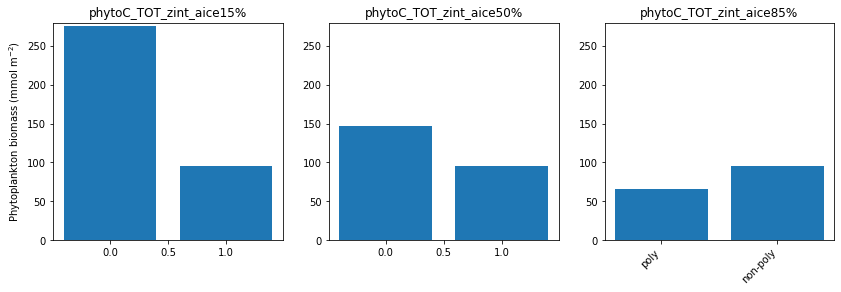

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
labels=['poly','non-poly']
ind=[0,1]
var = 'phytoC_TOT_zint'
thres_var = 'aice'

#15%
thres = '15%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[0].bar(ind, vals)
ax[0].set_title(var + '_' + thres_var + thres)
ax[0].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[0].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

#50%
thres = '50%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[1].bar(ind, vals)
ax[1].set_title(var + '_' + thres_var + thres)
ax[1].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

#85%
thres = '85%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[2].bar(ind, vals)
ax[2].set_title(var + '_' + thres_var + thres)
#ax[2].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[2].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

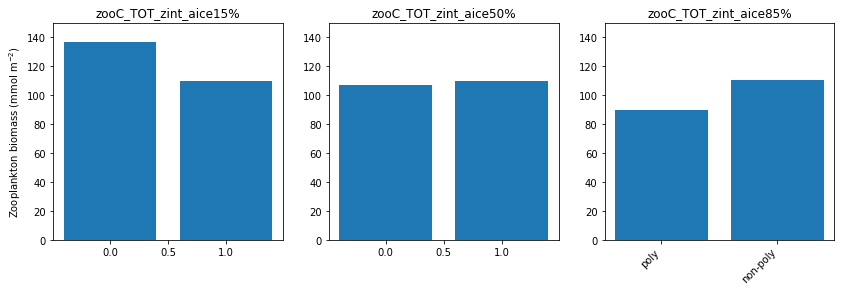

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
labels=['poly','non-poly']
ind=[0,1]
var = 'zooC_TOT_zint'
thres_var = 'aice'

#15%
thres = '15%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[0].bar(ind, vals)
ax[0].set_title(var + '_' + thres_var + thres)
ax[0].set_ylabel('Zooplankton biomass (mmol m$^{-2}$)')
ax[0].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');

#50%
thres = '50%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[1].bar(ind, vals)
ax[1].set_title(var + '_' + thres_var + thres)
ax[1].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');

#85%
thres = '85%'
vals=[polys[var + '_' + thres_var + thres],non_polys[var+ '_' + thres_var + thres]]
ax[2].bar(ind, vals)
ax[2].set_title(var + '_' + thres_var + thres)
#ax[2].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[2].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');

### now do hi thresholds

In [ ]:
ts_polys = xr.Dataset({v: ds[v] for v in ['time']})
ts_non_polys = xr.Dataset({v: ds[v] for v in ['time']})

In [32]:
thres_var = 'hi'

for var in variables:
    
    for thres in ['0.15m','0.5m','0.85m']:
        
        print(var, thres)

        path = '/glade/p/cesm/pcwg/landrum/' + case + '/ice/polynyas/monthly/'

        ds_poly = get_data(path,case,thres_var,thres)

        ds_poly = ds_poly.rename({'lon': 'nlon','lat': 'nlat'})

        ds_poly['time'] = ds.time
        ds['polynyas'] = ds_poly['polynyas']
        ds  = ds.where(ds_grid.REGION_MASK>0)

        masked  = ds[var].where(ds['polynyas']>0.) #doing all polynyas, coastal and open water
        
        ts_polys[var + '_' + thres_var + thres] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()
        
        masked = ds[var].where(ds['IFRAC']>0.15).where(ds['polynyas']==0)

        ts_non_polys[var + '_' + thres_var + thres] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

phytoC_TOT_zint 0.15m
phytoC_TOT_zint 0.5m
phytoC_TOT_zint 0.85m
zooC_TOT_zint 0.15m
zooC_TOT_zint 0.5m
zooC_TOT_zint 0.85m


In [33]:
polys2 = ts_polys.mean(dim='time')
non_polys2 = ts_non_polys.mean(dim='time')

### compare thresholds

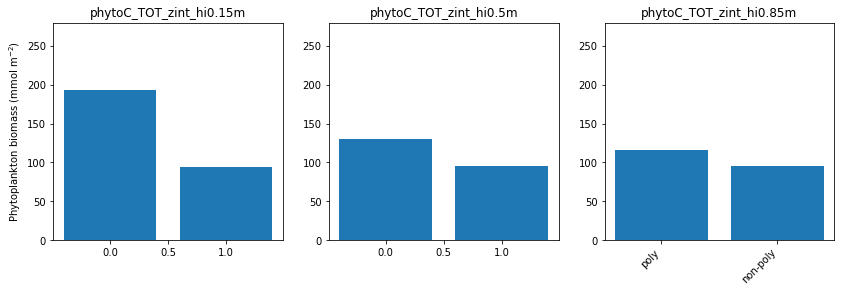

In [34]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
labels=['poly','non-poly']
ind=[0,1]
var = 'phytoC_TOT_zint'
thres_var = 'hi'

#0.15m
thres = '0.15m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[0].bar(ind, vals)
ax[0].set_title(var + '_' + thres_var + thres)
ax[0].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[0].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

#0.50m
thres = '0.5m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[1].bar(ind, vals)
ax[1].set_title(var + '_' + thres_var + thres)
ax[1].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

#0.85m
thres = '0.85m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[2].bar(ind, vals)
ax[2].set_title(var + '_' + thres_var + thres)
#ax[2].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[2].set_ylim(0,280)
plt.xticks(ind, labels,rotation=45, ha='right');

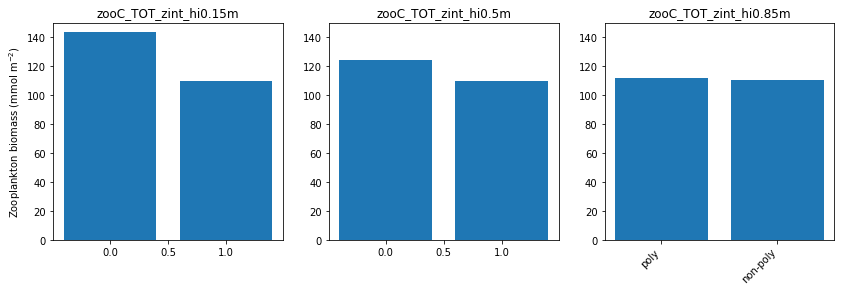

In [36]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
labels=['poly','non-poly']
ind=[0,1]
var = 'zooC_TOT_zint'
thres_var = 'hi'

#0.15m
thres = '0.15m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[0].bar(ind, vals)
ax[0].set_title(var + '_' + thres_var + thres)
ax[0].set_ylabel('Zooplankton biomass (mmol m$^{-2}$)')
ax[0].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');

#0.50m
thres = '0.5m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[1].bar(ind, vals)
ax[1].set_title(var + '_' + thres_var + thres)
ax[1].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');

#0.85m
thres = '0.85m'
vals=[polys2[var + '_' + thres_var + thres],non_polys2[var+ '_' + thres_var + thres]]
ax[2].bar(ind, vals)
ax[2].set_title(var + '_' + thres_var + thres)
#ax[2].set_ylabel('Phytoplankton biomass (mmol m$^{-2}$)')
ax[2].set_ylim(0,150)
plt.xticks(ind, labels,rotation=45, ha='right');